# The wormlike chain model

Requirements
+ matplotlib
+ numpy
+ scipy


<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb) -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Autoreload
# %load_ext autoreload
# %autoreload 2

In [ ]:
import numpy as np, matplotlib.pyplot as plt

class MinimalSquareDimers:
    """Close-packed dimers on an Lx x Ly square lattice with periodic BCs."""
    def __init__(self, Lx=20, Ly=20, seed=None):
        assert Lx % 2==0 and Ly % 2==0 ## Ensure that the lattice is even
        self.Lx, self.Ly = Lx, Ly
        self.rng = np.random.default_rng(seed)
        self.H = np.zeros((Ly, Lx), np.uint8)     # edge (x,y)-(x+1,y) occupied?
        self.V = np.zeros((Ly, Lx), np.uint8)     # edge (x,y)-(x,y+1) occupied?
        self.H[:, ::2] = 1                       # horizontal stripes = valid initial covering

    # ---- tiny helpers ----
    def _occ_edge_from(self, x, y):
        """Return neighbor of the unique occupied edge touching (x,y)."""
        xm, ym = (x-1)%self.Lx, (y-1)%self.Ly
        if self.H[y, xm]:  return ((x-1)%self.Lx, y)
        if self.H[y, x]:   return ((x+1)%self.Lx, y)
        if self.V[ym, x]:  return (x, (y-1)%self.Ly)
        if self.V[y, x]:   return (x, (y+1)%self.Ly)
        raise RuntimeError("Constraint broken")

    def _toggle(self, x1,y1,x2,y2):
        """XOR the edge occupancy on (x1,y1)-(x2,y2)."""
        if y1==y2:
            xlo = x1 if (x2-x1)%self.Lx==1 else x2
            self.H[y1, xlo] ^= 1
        else:
            ylo = y1 if (y2-y1)%self.Ly==1 else y2
            self.V[ylo, x1] ^= 1

    # ---- a) one local plaquette flip (do nothing if not flippable) ----
    def flip_plaquette_once(self):
        x = int(self.rng.integers(self.Lx)); y = int(self.rng.integers(self.Ly))
        xn, yn = (x+1)%self.Lx, (y+1)%self.Ly
        b, t, l, r = self.H[y,x], self.H[yn,x], self.V[y,x], self.V[y,xn]
        if (b and t and not l and not r) or (l and r and not b and not t):
            self.H[y,x] ^= 1; self.H[yn,x] ^= 1; self.V[y,x] ^= 1; self.V[y,xn] ^= 1
            return True
        return False

    # ---- b) one nonlocal loop (worm) update (uniform measure ⇒ accept=1) ----
    def loop_update_once(self, max_steps=10000):
        x0 = int(self.rng.integers(self.Lx)); y0 = int(self.rng.integers(self.Ly))
        xh, yh = self._occ_edge_from(x0, y0)      # break a dimer → two monomers
        self._toggle(x0,y0,xh,yh)
        tail, head = (x0,y0), (xh,yh)
        prev = tail
        for step in range(max_steps):
            x,y = head
            nbrs = [((x+1)%self.Lx,y),((x-1)%self.Lx,y),(x,(y+1)%self.Ly),(x,(y-1)%self.Ly)]
            nbrs = [nb for nb in nbrs if nb!=prev]    # avoid immediate backtrack
            # edge occupancy to each neighbor:
            occ = []
            for xn,yn in nbrs:
                if yn==y:
                    xlo = x if (xn-x)%self.Lx==1 else xn; occ.append(self.H[y,xlo])
                else:
                    ylo = y if (yn-y)%self.Ly==1 else yn; occ.append(self.V[ylo,x])
            want_occ = (step%2==0)                    # even: add (currently empty)
            cands = [nb for nb,o in zip(nbrs,occ) if o==want_occ] or nbrs
            nb = cands[self.rng.integers(len(cands))]
            self._toggle(x,y,nb[0],nb[1])
            prev, head = (x,y), nb
            if head==tail: return True
        # fail to close → revert the first break
        self._toggle(x0,y0,xh,yh); return False

    # ---- plotting ----
    def plot(self):
        fig, ax = plt.subplots(figsize=(5,5))
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.H[y,x] and (x+1)%self.Lx>x: ax.plot([x,x+1],[y,y], linewidth=3)
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.V[y,x] and (y+1)%self.Ly>y: ax.plot([x,x],[y,y+1], linewidth=3)
        ax.set_aspect('equal'); ax.set_xlim(0,self.Lx); ax.set_ylim(0,self.Ly)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_title("Square-lattice dimers")
        plt.show()
        return ax

D = MinimalSquareDimers(Lx=20, Ly=20, seed=1)
energies = [D.energy()]
for _ in range(1000): 
    D.flip_plaquette_once()
    energies.append(D.energy())
# for _ in range(200):  
#     D.loop_update_once()
#     energies.append(D.energy())

plt.plot(energies)

D.plot()

AttributeError: 'MinimalSquareDimers' object has no attribute 'energy'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MinimalSquareDimers:
    """Close-packed dimers on an Lx x Ly square lattice with periodic BCs.

    Args:
        Lx (int): Lattice size x (must be even).
        Ly (int): Lattice size y (must be even).
        seed (int | None): RNG seed for reproducibility.
        J (float): Nearest-neighbor (plaquette) aligning interaction strength.
                   J>0 favors two parallel dimers on a plaquette.
        beta (float): Inverse temperature 1/T (k_B=1).

    Attributes:
        Lx (int): Size in x.
        Ly (int): Size in y.
        rng (np.random.Generator): RNG.
        H (np.ndarray[uint8]): Occupancy of horizontal edges (y,x) for bond (x,y)-(x+1,y).
        V (np.ndarray[uint8]): Occupancy of vertical edges (y,x) for bond (x,y)-(x,y+1).
        J (float): Interaction strength.
        beta (float): Inverse temperature.
    """
    def __init__(self, Lx=20, Ly=20, seed=None, J=1.0, beta=1.0):
        assert Lx % 2==0 and Ly % 2==0  # Ensure that the lattice is even
        self.Lx, self.Ly = Lx, Ly
        self.rng = np.random.default_rng(seed)
        self.H = np.zeros((Ly, Lx), np.uint8)   # edge (x,y)-(x+1,y) occupied?
        self.V = np.zeros((Ly, Lx), np.uint8)   # edge (x,y)-(x,y+1) occupied?
        self.H[:, ::2] = 1                      # horizontal stripes = valid initial covering
        self.J = float(J)
        self.beta = float(beta)

    # ---- energy of interacting classical dimers (Alet–Jacobsen–Misguich model) ----
    def energy(self):
        """Return E = -J * (# plaquettes with two parallel dimers).

        A plaquette contributes -J if it has exactly the two horizontal bonds
        occupied (top & bottom) or exactly the two vertical bonds occupied (left & right).
        """
        E = 0.0
        for y in range(self.Ly):
            yn = (y+1) % self.Ly
            for x in range(self.Lx):
                xn = (x+1) % self.Lx
                b = self.H[y, x]        # bottom horizontal bond of plaquette (x,y)
                t = self.H[yn, x]       # top horizontal bond
                l = self.V[y, x]        # left vertical bond
                r = self.V[y, xn]       # right vertical bond
                if (b and t and not l and not r) or (l and r and not b and not t):
                    E -= self.J
        return E

    # ---- tiny helpers ----
    def _occ_edge_from(self, x, y):
        """Return neighbor of the unique occupied edge touching (x,y)."""
        xm, ym = (x-1)%self.Lx, (y-1)%self.Ly
        if self.H[y, xm]:  return ((x-1)%self.Lx, y)
        if self.H[y, x]:   return ((x+1)%self.Lx, y)
        if self.V[ym, x]:  return (x, (y-1)%self.Ly)
        if self.V[y, x]:   return (x, (y+1)%self.Ly)
        raise RuntimeError("Constraint broken")

    def _toggle(self, x1,y1,x2,y2):
        """XOR the edge occupancy on (x1,y1)-(x2,y2)."""
        if y1==y2:
            xlo = x1 if (x2-x1)%self.Lx==1 else x2
            self.H[y1, xlo] ^= 1
        else:
            ylo = y1 if (y2-y1)%self.Ly==1 else y2
            self.V[ylo, x1] ^= 1

    def _metropolis(self, dE):
        """Accept with prob min(1, exp(-beta * dE))."""
        return dE <= 0.0 or (self.rng.random() < np.exp(-self.beta * dE))

    # ---- a) one local plaquette flip with Metropolis (reject if not flippable) ----
    def flip_plaquette_once(self):
        x = int(self.rng.integers(self.Lx)); y = int(self.rng.integers(self.Ly))
        xn, yn = (x+1)%self.Lx, (y+1)%self.Ly
        b, t, l, r = self.H[y,x], self.H[yn,x], self.V[y,x], self.V[y,xn]
        flippable = (b and t and not l and not r) or (l and r and not b and not t)
        if not flippable:
            return False
        E0 = self.energy()
        # propose flip
        self.H[y,x] ^= 1; self.H[yn,x] ^= 1; self.V[y,x] ^= 1; self.V[y,xn] ^= 1
        dE = self.energy() - E0
        if self._metropolis(dE):
            return True
        # reject → undo
        self.H[y,x] ^= 1; self.H[yn,x] ^= 1; self.V[y,x] ^= 1; self.V[y,xn] ^= 1
        return False

    # ---- b) one nonlocal loop (worm) update with Metropolis on the closed loop ----
    def loop_update_once(self, max_steps=10000):
        # save state to allow rejection
        H0, V0 = self.H.copy(), self.V.copy()
        E0 = self.energy()

        x0 = int(self.rng.integers(self.Lx)); y0 = int(self.rng.integers(self.Ly))
        xh, yh = self._occ_edge_from(x0, y0)      # break a dimer → two monomers
        self._toggle(x0,y0,xh,yh)
        tail, head = (x0,y0), (xh,yh)
        prev = tail
        for step in range(max_steps):
            x,y = head
            nbrs = [((x+1)%self.Lx,y),((x-1)%self.Lx,y),(x,(y+1)%self.Ly),(x,(y-1)%self.Ly)]
            nbrs = [nb for nb in nbrs if nb!=prev]    # avoid immediate backtrack
            # edge occupancy to each neighbor:
            occ = []
            for xn,yn in nbrs:
                if yn==y:
                    xlo = x if (xn-x)%self.Lx==1 else xn; occ.append(self.H[y,xlo])
                else:
                    ylo = y if (yn-y)%self.Ly==1 else yn; occ.append(self.V[ylo,x])
            want_occ = (step%2==0)                    # even: add (currently empty)
            cands = [nb for nb,o in zip(nbrs,occ) if o==want_occ] or nbrs
            nb = cands[self.rng.integers(len(cands))]
            self._toggle(x,y,nb[0],nb[1])
            prev, head = (x,y), nb
            if head==tail:
                # proposed new perfect matching; Metropolis test on total energy
                dE = self.energy() - E0
                if self._metropolis(dE):
                    return True
                # reject → restore
                self.H[:], self.V[:] = H0, V0
                return False

        # fail to close → restore and reject
        self.H[:], self.V[:] = H0, V0
        return False

    # ---- plotting ----
    def plot(self):
        fig, ax = plt.subplots(figsize=(5,5))
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.H[y,x] and (x+1)%self.Lx>x: ax.plot([x,x+1],[y,y], linewidth=3)
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.V[y,x] and (y+1)%self.Ly>y: ax.plot([x,x],[y,y+1], linewidth=3)
        ax.set_aspect('equal'); ax.set_xlim(0,self.Lx); ax.set_ylim(0,self.Ly)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_title("Square-lattice dimers")
        plt.show()
        return ax


In [ ]:
import numpy as np
from dataclasses import dataclass

def rand_unit_vec(rng: np.random.Generator) -> np.ndarray:
    """
    Args:
        rng (np.random.Generator): RNG.

    Returns:
        np.ndarray: Random unit vector on S^2 (shape (3,)).
    """
    z = rng.uniform(-1.0, 1.0)
    phi = rng.uniform(0.0, 2.0 * np.pi)
    r = np.sqrt(max(0.0, 1.0 - z * z))
    return np.array([r * np.cos(phi), r * np.sin(phi), z], dtype=float)


@dataclass
class Bond:
    """Unit-length bond/tangent vector in R^3 with in-place rotations.

    Parameters:
        v (np.ndarray): Initial vector (shape (3,)); will be normalized.

    Attributes:
        v (np.ndarray): Unit vector (shape (3,)).
    """
    v: np.ndarray

    def __post_init__(self):
        self.set_vec(self.v)

    def set_vec(self, v: np.ndarray) -> None:
        """Assign vector and renormalize to unit length."""
        v = np.asarray(v, dtype=float).reshape(3)
        n = np.linalg.norm(v)
        if n == 0.0:
            raise ValueError("Zero vector is not allowed for Bond.")
        self.v = v / n

    def rotate_in_place(self, axis: np.ndarray, angle: float) -> None:
        """Rotate about an arbitrary axis by Rodrigues' formula; re-normalize."""
        a = np.asarray(axis, dtype=float).reshape(3)
        na = np.linalg.norm(a)
        if na == 0.0:
            # Degenerate axis: no rotation
            return
        a /= na
        c, s = np.cos(angle), np.sin(angle)
        v = self.v
        # Rodrigues rotation
        v_rot = v * c + np.cross(a, v) * s + a * (np.dot(a, v)) * (1.0 - c)
        # Guard against FP drift
        self.v = v_rot / np.linalg.norm(v_rot)

    # Numpy interop: treat Bond like its vector
    def __array__(self, dtype=None):
        return np.asarray(self.v, dtype=dtype)

    def copy(self) -> "Bond":
        return Bond(self.v.copy())


class WormlikeChainMC:
    """Discrete 3D wormlike chain with Metropolis updates in tangent space.

    The chain is represented by N unit bond vectors (Bond objects) of fixed length b.
    Positions are reconstructed by r_{k+1} = r_k + b t_k (with r_0 at the origin).
    Bending energy: E = kappa * sum_i (1 - t_i · t_{i+1}).

    Parameters:
        N (int): Number of bonds.
        b (float): Bond length (segment length).
        kappa (float): Bending stiffness (k_B T units). Persistence length l_p = kappa * b.
        beta (float): Inverse temperature 1/T (k_B=1).
        seed (int | None): RNG seed.

    Attributes:
        N (int): Number of bonds.
        b (float): Bond length.
        kappa (float): Bending stiffness.
        beta (float): Inverse temperature.
        rng (np.random.Generator): RNG.
        bonds (list[Bond]): List of N Bond instances (unit vectors).
    """
    def __init__(self, N=400, b=1.0, kappa=20.0, beta=1.0, seed=None):
        self.N, self.b = int(N), float(b)
        self.kappa, self.beta = float(kappa), float(beta)
        self.rng = np.random.default_rng(seed)

        # start nearly straight with small transverse noise, then normalize per Bond
        base = np.tile(np.array([1.0, 0.0, 0.0], dtype=float), (self.N, 1))
        base += 0.05 * self.rng.normal(size=base.shape)
        self.bonds = [Bond(v) for v in base]

    # ---- helpers ----
    def _t_array(self) -> np.ndarray:
        """Stack current bond vectors as (N,3) ndarray (no copies of leaf arrays)."""
        return np.vstack([b.v for b in self.bonds])

    def positions(self) -> np.ndarray:
        """Return positions r_k, k=0..N as shape (N+1,3) with r_0 = 0."""
        r = np.zeros((self.N + 1, 3), dtype=float)
        np.cumsum(self.b * self._t_array(), axis=0, out=r[1:])
        return r

    def energy(self) -> float:
        """Total bending energy."""
        t = self._t_array()
        dots = (t[:-1] * t[1:]).sum(axis=1)
        return float(self.kappa * np.sum(1.0 - dots))

    def _local_deltaE(self, i: int, trial_vec: np.ndarray) -> float:
        """Energy change from replacing t_i by trial_vec (only neighbors matter)."""
        dE = 0.0
        if i > 0:
            dE += self.kappa * ((1.0 - float(np.dot(trial_vec, self.bonds[i - 1].v)))
                                - (1.0 - float(np.dot(self.bonds[i].v, self.bonds[i - 1].v))))
        if i < self.N - 1:
            dE += self.kappa * ((1.0 - float(np.dot(trial_vec, self.bonds[i + 1].v)))
                                - (1.0 - float(np.dot(self.bonds[i].v, self.bonds[i + 1].v))))
        return float(dE)

    def sweep(self, step_size: float = 0.3) -> dict:
        """
        One Monte Carlo sweep consists of attempting N local rotations.

        Args:
            step_size (float): Typical rotation angle (radians) for proposals.

        Returns:
            dict: {'acc': float, 'E': float} Whether the rotation was accepted and 
                the energy.
        """
        acc = 0
        for _ in range(self.N):
            i = int(self.rng.integers(self.N))  # choose a random bond
            axis = rand_unit_vec(self.rng)      # random axis
            angle = self.rng.normal(scale=step_size)

            # propose rotated vector (without mutating)
            trial = self.bonds[i].copy()
            trial.rotate_in_place(axis, angle)
            t_new = trial.v  # guaranteed unit length

            dE = self._local_deltaE(i, t_new)
            if dE <= 0.0 or self.rng.random() < np.exp(-self.beta * dE):
                # accept: rotate in place (keeps unit length by construction)
                self.bonds[i].rotate_in_place(axis, angle)
                acc += 1
        return {"acc": acc / self.N, "E": self.energy()}

    def end_to_end(self):
        """Return end-to-end vector R and its squared length."""
        R = self.b * self._t_array().sum(axis=0)
        return R, float(np.dot(R, R))

    def tangent_correlation(self):
        """Compute C(s) = <t_i · t_{i+s}> averaged over i.

        Returns:
            (np.ndarray, np.ndarray): separations s, correlations C(s).
        """
        max_sep = (self.N - 1) // 4 # Largest separation is 1/4 of chain length
        s_vals = np.arange(0, max_sep + 1, dtype=int)
        t = self._t_array()
        C = np.zeros_like(s_vals, dtype=float)
        for si, s in enumerate(s_vals):
            dots = (t[: self.N - s] * t[s:]).sum(axis=1)
            C[si] = float(np.mean(dots))
        return s_vals, C
    

    def simulate(self, n_eq):
        """
        Simulate the wormlike chain and return observables.

        Args:
            n_eq (int): Number of of sweeps to equilibrate the chain.
            step_size (float): Proposal rotation angle scale (radians).
            seed (int): RNG seed.

        Returns:
            dict: {'E': np.ndarray, 'R2': np.ndarray, 'acc': np.ndarray, 't_corr': (s, C), 'chain': WormlikeChainMC}
        """

        # equilibrate the chain
        for _ in range(n_eq):
            self.sweep(step_size=step_size)

        # # # measure
        # # E_list, R2_list, A_list = [], [], []
        for _ in range(n_meas):
            stats = mc.sweep(step_size=step_size)
            _, R2 = mc.end_to_end()
        # #     E_list.append(stats["E"]); R2_list.append(R2); A_list.append(stats["acc"])

        # s, C = mc.tangent_correlation(max_sep=(N // 4))


        # # s, C, C_conn = tangent_correlation_connected(mc._t_array(), max_sep=min(200, N-1))
        
        # return {
        #     "E": np.array(E_list),
        #     "R2": np.array(R2_list),
        #     "acc": np.array(A_list),
        #     "t_corr": (s, C),
        #     "chain": mc,
        # }
        

def demo_wlc(N=400, b=1.0, kappa=30.0, beta=1.0, n_eq=2000, n_meas=2000, step_size=0.25, seed=0):
    """
    Run a simple WLC simulation and return observables.

    Args:
        N (int): Number of bonds.
        b (float): Bond length.
        kappa (float): Bending stiffness; persistence length l_p = kappa * b.
        beta (float): Inverse temperature.
        n_eq (int): Number of equilibration sweeps.
        n_meas (int): Number of measurement sweeps (with recording).
        step_size (float): Proposal rotation angle scale (radians).
        seed (int): RNG seed.

    Returns:
        dict: {'E': np.ndarray, 'R2': np.ndarray, 'acc': np.ndarray, 't_corr': (s, C), 'chain': WormlikeChainMC}
    """
    mc = WormlikeChainMC(N=N, b=b, kappa=kappa, beta=beta, seed=seed)

    # equilibrate
    for _ in range(n_eq):
        mc.sweep(step_size=step_size)

    # measure
    E_list, R2_list, A_list = [], [], []
    for _ in range(n_meas):
        stats = mc.sweep(step_size=step_size)
        _, R2 = mc.end_to_end()
        E_list.append(stats["E"]); R2_list.append(R2); A_list.append(stats["acc"])

    s, C = mc.tangent_correlation(max_sep=(N // 4))


    # s, C, C_conn = tangent_correlation_connected(mc._t_array(), max_sep=min(200, N-1))
    
    return {
        "E": np.array(E_list),
        "R2": np.array(R2_list),
        "acc": np.array(A_list),
        "t_corr": (s, C),
        "chain": mc,
    }

# if __name__ == "__main__":
#     out = demo_wlc(N=400, b=1.0, kappa=30.0, n_eq=1500, n_meas=1000, step_size=0.2, seed=1)
#     R2_mean = out["R2"].mean()
#     lp = out["chain"].kappa * out["chain"].b
#     L = out["chain"].N * out["chain"].b
#     print(f"<R^2> ~ {R2_mean:.2f}, L = {L:.1f}, l_p = {lp:.1f}")
#     # Quick theoretical check (Kratky–Porod continuum limit): <R^2> = 2 l_p L [1 - l_p/L (1 - e^{-L/l_p})]
#     L_over_lp = L / lp
#     R2_KP = 2*lp*L*(1.0 - (1.0 - np.exp(-L_over_lp))/L_over_lp)
#     print(f"Kratky-Porod prediction ~ {R2_KP:.2f}")

KeyboardInterrupt: 

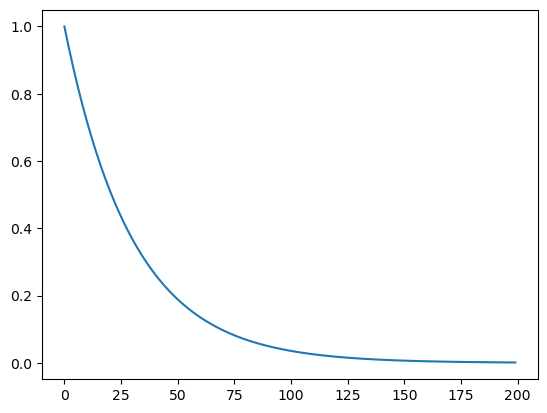

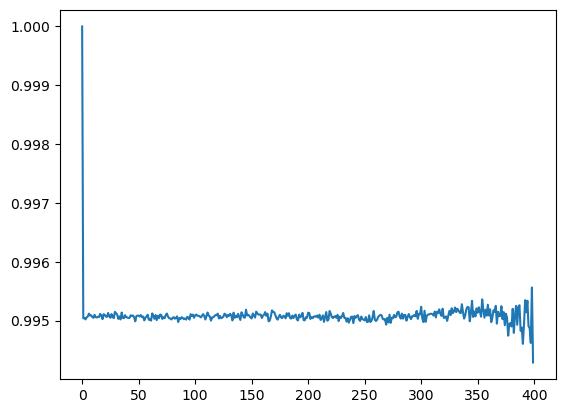

In [75]:
plt.plot(np.array(all_tcorr).mean(axis=0))
# plt.plot(np.exp(-np.arange(200) / lp))


/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_35929/3000541427.py:1: RuntimeWarning: Mean of empty slice.
  plt.semilogy(np.array(all_tcorr).mean(axis=0))


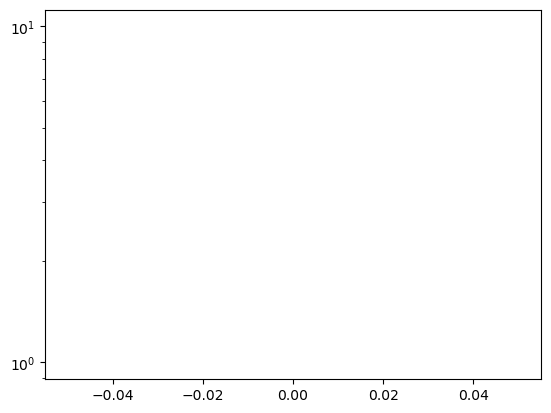

In [66]:
plt.semilogy(np.array(all_tcorr).mean(axis=0))
# plt.semilogy(np.exp(-np.arange(200) / lp / 0.15))

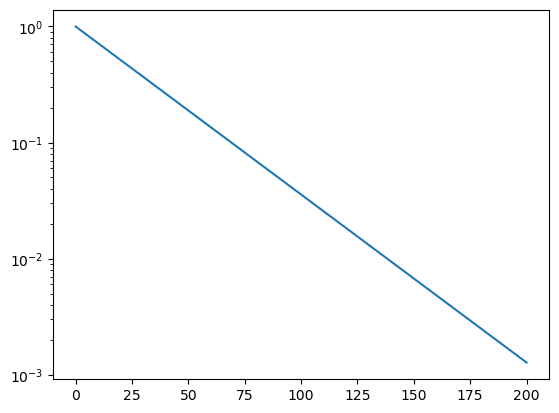

In [43]:
plt.semilogy(np.exp(-out["t_corr"][0] / lp))


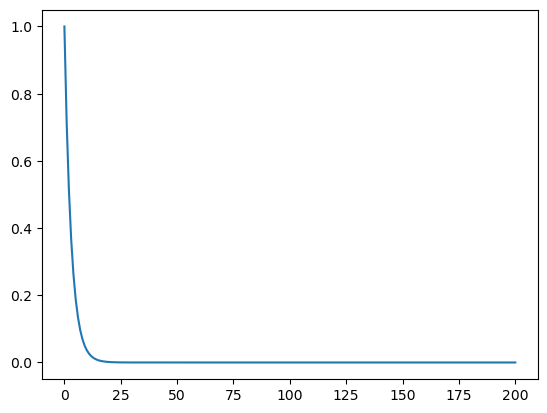

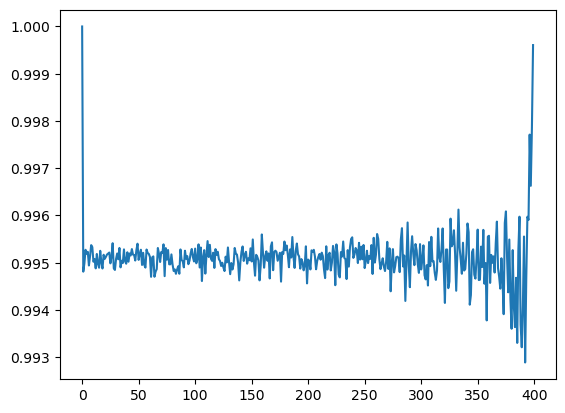

In [73]:
plt.plot(mc.tangent_correlation(max_sep=400)[1])

seed=0
seed=1
seed=2
seed=3
seed=4
seed=5
seed=6
seed=7
seed=8
seed=9
seed=10
seed=11
seed=12
seed=13
seed=14
seed=15
seed=16
seed=17
seed=18
seed=19
seed=20
seed=21
seed=22
seed=23
seed=24
seed=25
seed=26
seed=27
seed=28
seed=29


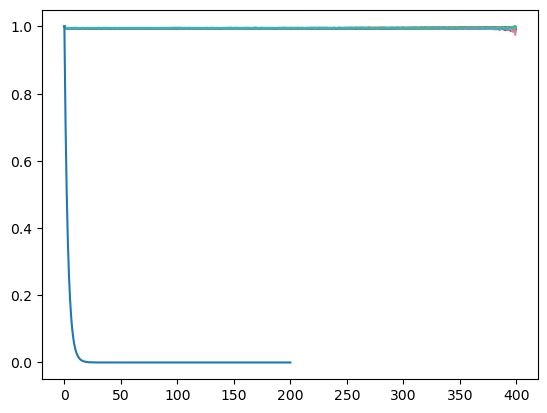

In [69]:
all_tcorr = []
for seed in range(30):
    print(f"seed={seed}", flush=True)
    # out = demo_wlc(N=400, b=1.0, kappa=30.0, n_eq=500, n_meas=500, step_size=0.2, seed=seed, beta=0.1)
    mc = WormlikeChainMC(N=400, b=1.0, kappa=30.0, beta=0.1, seed=seed)
    all_tcorr.append(mc.tangent_correlation(max_sep=400)[1])
    # plt.plot(out["t_corr"][0], out["t_corr"][1], label=f"seed={seed}")
    plt.plot(mc.tangent_correlation(max_sep=400)[0], mc.tangent_correlation(max_sep=400)[1], label=f"seed={seed}")

plt.plot(np.exp(-out["t_corr"][0] / lp / 0.1))


(array([30., 77., 26., 10., 39., 60., 18., 60., 52., 28.]),
 array([15832.35347773, 17378.44479207, 18924.53610641, 20470.62742075,
        22016.71873508, 23562.81004942, 25108.90136376, 26654.9926781 ,
        28201.08399244, 29747.17530677, 31293.26662111]),
 <BarContainer object of 10 artists>)

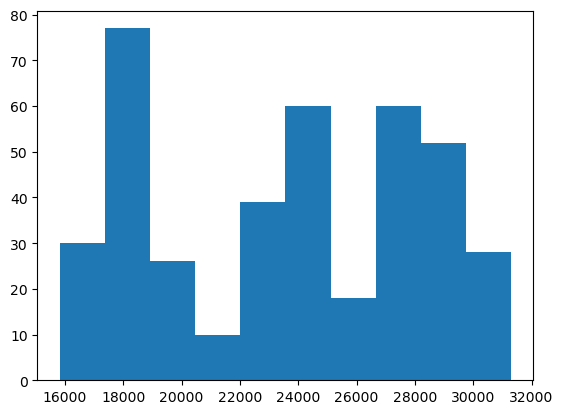

In [57]:
plt.hist(out["R2"][100:])

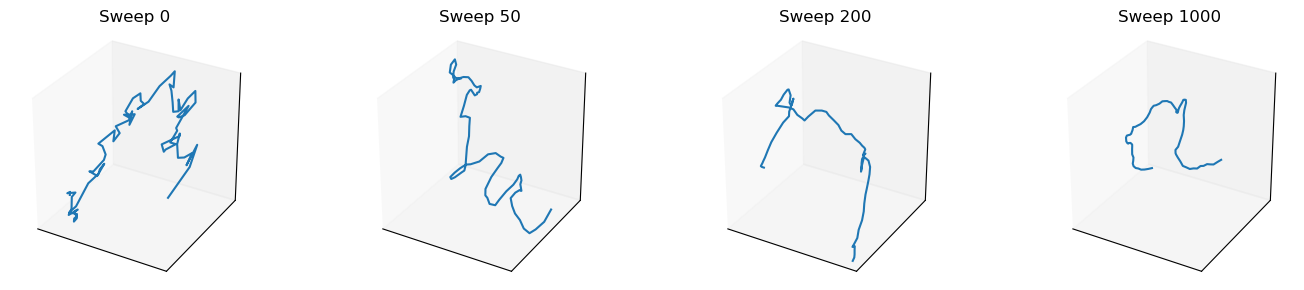

In [3]:
# Simplify: use shorter chain (N=80) and fewer sweeps to avoid long runtime
mc = WormlikeChainMC(N=80, b=1.0, kappa=20.0, beta=1.0, seed=0)
configs = []
steps_to_save = [0, 50, 200, 1000]

configs.append((0, mc.positions()))
for sweep in range(1, max(steps_to_save) + 1):
    mc.sweep(step_size=0.25)
    if sweep in steps_to_save:
        configs.append((sweep, mc.positions()))

# Plot
fig, axes = plt.subplots(1, len(configs), figsize=(14, 3), subplot_kw={"projection": "3d"})
for ax, (sweep, r) in zip(axes, configs):
    ax.plot(r[:, 0], r[:, 1], r[:, 2], lw=1.5)
    ax.set_title(f"Sweep {sweep}")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# --- Theory you can test against (k_B T = 1 units) ---

def wlc_lp_from_kappa_b(kappa: float, b: float) -> float:
    """Return persistence length lp = kappa * b."""
    return float(kappa) * float(b)

def wlc_R2_theory(L: float, lp: float) -> float:
    """<R^2> = 2 lp L [1 - (lp/L)(1 - exp(-L/lp))]."""
    L, lp = float(L), float(lp)
    return 2.0 * lp * L * (1.0 - (lp / L) * (1.0 - np.exp(-L / lp)))

def wlc_C_theory(s_idx: np.ndarray, b: float, lp: float) -> np.ndarray:
    """Tangent correlation C(s) = exp(-s b / lp) for integer separations s."""
    return np.exp(-np.asarray(s_idx, dtype=float) * b / lp)

def wlc_Rg2_theory(L: float, lp: float, n_quad: int = 2000) -> float:
    """
    Exact R_g^2 from the continuum integral using C(|s-s'|)=exp(-|s-s'|/lp):
        Rg^2 = (1/2L^2) ∫_0^L ds ∫_0^L ds' ⟨(r(s)-r(s'))^2⟩
             = (1/L^2) ∫_0^L ds ∫_0^s du 2 ∫_u^s ∫_u^s ds1 ds2 e^{-|s1-s2|/lp}.
    Evaluated by vectorized quadrature (stable and fast for classroom N).
    """
    L, lp = float(L), float(lp)
    # Use a known closed form is possible, but this quadrature avoids algebra slips.
    # Discretize s on a uniform grid and integrate with trapezoid rule.
    s = np.linspace(0.0, L, n_quad)
    ds = s[1] - s[0]
    # Build kernel K(i,j) = e^{-|s_i - s_j|/lp}
    diff = np.abs(s[:, None] - s[None, :])
    K = np.exp(-diff / lp)
    # For each pair (u<=s), inner double integral over [u,s]x[u,s] of K
    # Use cumulative sums to get all box integrals in O(n^2).
    Kc = K.cumsum(axis=0).cumsum(axis=1) * (ds**2)  # 2D integral from (0,0) to (i,j)
    def box_int(i, j):  # ∫_0^{s_i} ∫_0^{s_j} K
        return Kc[i, j]
    tot = 0.0
    for i in range(n_quad):          # s index
        for j in range(i + 1):       # u index, u<=s
            # integral over [u,s]x[u,s] is I(s,s)-I(u,s)-I(s,u)+I(u,u)
            I = box_int(i, i) - box_int(j, i) - box_int(i, j) + box_int(j, j)
            tot += 2.0 * I
    Rg2 = (1.0 / (L * L)) * tot * (ds**0)  # ds factors already accounted in I
    return float(Rg2)

def marko_siggia_extension_fraction(f: float, L: float, lp: float) -> float:
    """
    Marko–Siggia interpolation (inextensible WLC):
      (f lp) = (1/4)(1 - x)^(-2) - 1/4 + x,  where x = z/L.
    Solve for x via Newton steps (monotone and robust 0<x<1).
    """
    flp = float(f) * float(lp)
    x = min(0.99, max(0.0, flp / (1.0 + flp)))  # good initial guess
    for _ in range(40):
        g = 0.25 * (1.0 - x)**-2 - 0.25 + x - flp
        dg = 0.5 * (1.0 - x)**-3 + 1.0
        step = g / dg
        x_new = x - step
        x = min(0.999999, max(0.0, x_new))
        if abs(step) < 1e-12:
            break
    return float(x)

# --- Minimal measurement helpers for your existing WLC MC code ---

def measure_R2(chain) -> float:
    """Compute end-to-end mean square from current configuration."""
    R = chain.b * chain.t.sum(axis=0)
    return float(R @ R)

def measure_Rg2(chain) -> float:
    """Compute radius of gyration from current configuration positions."""
    r = chain.positions()
    rc = r.mean(axis=0)
    d2 = ((r - rc) ** 2).sum(axis=1)
    return float(d2.mean())

def measure_C_of_s(chain, max_s: int | None = None) -> tuple[np.ndarray, np.ndarray]:
    """Return separations s and C(s)=<t_i·t_{i+s}> averaged over i."""
    N = chain.N
    if max_s is None: max_s = N - 1
    s_vals = np.arange(0, max_s + 1, dtype=int)
    C = np.zeros_like(s_vals, dtype=float)
    for k, s in enumerate(s_vals):
        dots = (chain.t[: N - s] * chain.t[s:]).sum(axis=1)
        C[k] = float(np.mean(dots))
    return s_vals, C

def sweep_with_force(chain, step_size=0.25, force=0.0, axis=(0.0, 0.0, 1.0)):
    """
    Like your sweep(), but adds -f * b * Σ_i (t_i · axis) to the energy.
    Only the changed site contributes to ΔE_force locally.
    """
    a = np.asarray(axis, dtype=float); a /= np.linalg.norm(a)
    acc = 0
    for _ in range(chain.N):
        i = int(chain.rng.integers(chain.N))
        # propose rotation
        axis_rand = rand_unit_vec(chain.rng)
        angle = chain.rng.normal(scale=step_size)
        t_new = rotate_vec(chain.t[i], axis_rand, angle); t_new /= np.linalg.norm(t_new)
        # local bending ΔE (your _local_deltaE)
        dE_bend = chain._local_deltaE(i, t_new)
        # local force ΔE
        dE_force = -force * chain.b * (np.dot(t_new, a) - np.dot(chain.t[i], a))
        dE = dE_bend + dE_force
        if dE <= 0.0 or chain.rng.random() < np.exp(-chain.beta * dE):
            chain.t[i] = t_new; acc += 1
    return acc / chain.N

def test_suite(chain, n_eq=2000, n_meas=2000, step_size=0.25, forces=(0.0, 0.05, 0.1)):
    """
    Equilibrate, then compare simulation to analytics:
    - ⟨R^2⟩ vs exact WLC formula
    - R_g^2 vs integral-theory
    - C(s) vs exp(-s b / lp)
    - force–extension (Marko–Siggia) at a few f
    Returns a compact dict of relative errors and raw arrays.
    """
    # persistence and contour length
    L = chain.N * chain.b
    lp = wlc_lp_from_kappa_b(chain.kappa, chain.b)

    # equilibrate
    for _ in range(n_eq): chain.sweep(step_size=step_size)

    # measurements
    R2_vals = []
    for _ in range(n_meas):
        chain.sweep(step_size=step_size)
        R2_vals.append(measure_R2(chain))
    R2_sim = float(np.mean(R2_vals))
    R2_th = wlc_R2_theory(L, lp)

    # Rg^2 from one well-equilibrated snapshot (or average a few)
    Rg2_sim = measure_Rg2(chain)
    Rg2_th = wlc_Rg2_theory(L, lp)

    # Tangent correlation
    s_sim, C_sim = measure_C_of_s(chain, max_s=min(100, chain.N - 1))
    C_th = wlc_C_theory(s_sim, chain.b, lp)
    # root-mean-square deviation on 1..S (skip s=0)
    rmsd_C = float(np.sqrt(np.mean((C_sim[1:] - C_th[1:]) ** 2)))

    # Force–extension
    f_rows = []
    for f in forces:
        # clone a light copy
        tmp = WormlikeChainMC(N=chain.N, b=chain.b, kappa=chain.kappa, beta=chain.beta, seed=1234)
        for _ in range(n_eq // 2):
            sweep_with_force(tmp, step_size=step_size, force=f)
        z_over_L = []
        for _ in range(n_meas // 10):
            sweep_with_force(tmp, step_size=step_size, force=f)
            # z/L = (b sum t_i·z)/L
            z = tmp.b * tmp.t[:, 2].sum()
            z_over_L.append(z / L)
        x_sim = float(np.mean(z_over_L))
        x_th = marko_siggia_extension_fraction(f, L, lp)
        f_rows.append((f, x_sim, x_th))

    return {
        "R2": {"sim": R2_sim, "theory": R2_th, "rel_err": (R2_sim - R2_th) / R2_th},
        "Rg2": {"sim": Rg2_sim, "theory": Rg2_th, "rel_err": (Rg2_sim - Rg2_th) / Rg2_th},
        "C": {"s": s_sim, "sim": C_sim, "theory": C_th, "rmsd": rmsd_C},
        "F_ext": [{"f": f, "x_sim": xs, "x_MS": xt, "abs_err": xs - xt} for f, xs, xt in f_rows],
        "L": L, "lp": lp,
    }


test_suite(

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

class RandomDimerModel:
    """
    1D tight-binding random dimer model (RDM):
      H = sum_n [ ε_n |n><n| - t ( |n><n+1| + |n+1><n| ) ]
    with ε_n taking two values {va, vb} but inserted as *dimers* (pairs).
    """
    def __init__(self, N=2000, t=1.0, va=-0.5, vb=+0.5, pair_prob=0.5, seed=None):
        """
        N: chain length
        t: nearest-neighbor hopping
        va, vb: onsite energies for the two species
        pair_prob: P(dimer == 'a'); otherwise 'b'
        """
        self.N = int(N)
        self.t = float(t)
        self.va, self.vb = float(va), float(vb)
        self.pair_prob = float(pair_prob)
        self.rng = np.random.default_rng(seed)
        self.eps = self._make_random_dimer_sequence()
        self._ham_cache_dense = None
        self._ham_cache_sparse = None
        self._spec = None  # (evals, evecs) once computed

    # ---------- core construction ----------
    def _make_random_dimer_sequence(self):
        eps = np.empty(self.N, dtype=float)
        i = 0
        while i < self.N:
            kind_a = self.rng.random() < self.pair_prob
            val = self.va if kind_a else self.vb
            if i == self.N - 1:
                eps[i] = val
                i += 1
            else:
                eps[i:i+2] = val
                i += 2
        return eps

    def hamiltonian_sparse(self):
        if self._ham_cache_sparse is None:
            main = self.eps
            off = -self.t * np.ones(self.N-1)
            self._ham_cache_sparse = diags([main, off, off], [0, -1, 1], format='csc')
        return self._ham_cache_sparse

    def hamiltonian_dense(self):
        if self._ham_cache_dense is None:
            H = np.diag(self.eps)
            off = -self.t * np.ones(self.N-1)
            H[np.arange(self.N-1), np.arange(1, self.N)] = off
            H[np.arange(1, self.N), np.arange(self.N-1)] = off
            self._ham_cache_dense = H
        return self._ham_cache_dense

    # ---------- spectra & observables ----------
    def spectrum(self, k=None):
        """
        Return (evals, evecs). If k is None or k >= N, uses dense solver.
        For large N, choose k << N (e.g., 400) for partial spectrum with eigsh.
        """
        if k is None or k >= self.N:
            evals, evecs = LA.eigh(self.hamiltonian_dense())
        else:
            # Center the spectrum around 0 by shift-invert if desired; here simple eigsh extremes + middle sweep
            # We get k//2 lowest, k//2 highest, then merge (simple & robust).
            k_low = k//2
            k_high = k - k_low
            Hs = self.hamiltonian_sparse()
            lo_vals, lo_vecs = eigsh(Hs, k=k_low, which='SA')
            hi_vals, hi_vecs = eigsh(Hs, k=k_high, which='LA')
            evals = np.concatenate([lo_vals, hi_vals])
            evecs = np.concatenate([lo_vecs, hi_vecs], axis=1)
            order = np.argsort(evals)
            evals, evecs = evals[order], evecs[:, order]
        self._spec = (evals, evecs)
        return evals, evecs

    def ipr(self, evecs=None):
        """Inverse Participation Ratio of eigenvectors: IPR(ψ)=∑|ψ_n|^4."""
        if evecs is None:
            if self._spec is None: self.spectrum()
            evecs = self._spec[1]
        return np.sum(np.abs(evecs)**4, axis=0)

    def dos(self, bins=200, rng=None, eigenvalues=None):
        """Density of states (histogram of eigenvalues)."""
        if eigenvalues is None:
            if self._spec is None: self.spectrum()
            eigenvalues = self._spec[0]
        if rng is None:
            bandwidth = 2*abs(self.t) + max(abs(self.va), abs(self.vb)) + 1e-6
            rng = (-bandwidth, +bandwidth)
        hist, edges = np.histogram(eigenvalues, bins=bins, range=rng, density=True)
        centers = 0.5*(edges[:-1] + edges[1:])
        return centers, hist

    # ---------- transfer matrix / Lyapunov exponent ----------
    def lyapunov(self, E, periodic_bc=False):
        """
        Compute Lyapunov exponent γ(E) via product of 2x2 transfer matrices.
        For large N this estimates the inverse localization length.
        """
        t = self.t
        # Avoid exact singularities
        eps = self.eps
        # Initialize with a random unit vector to reduce alignment bias
        v = np.array([1.0, 0.0])
        log_norm_sum = 0.0
        count = 0
        for n in range(self.N):
            M = np.array([[ (E - eps[n])/t, -1.0 ], [ 1.0, 0.0 ]], dtype=float)
            v = M @ v
            nrm = np.hypot(v[0], v[1])
            if nrm == 0:  # rare; reset
                v = np.array([1.0, 0.0])
                continue
            v /= nrm
            log_norm_sum += np.log(nrm)
            count += 1
        # Optional boundary closure (minor effect on large N)
        if periodic_bc:
            M_bc = np.array([[ (E - eps[0])/t, -1.0 ], [ 1.0, 0.0 ]], dtype=float)
            v = M_bc @ v
            log_norm_sum += np.log(np.hypot(v[0], v[1]))
            count += 1
        return log_norm_sum / max(count,1)

    def lyapunov_scan(self, Emin=None, Emax=None, nE=401):
        if Emin is None or Emax is None:
            bw = 2*abs(self.t) + max(abs(self.va), abs(self.vb)) + 1e-3
            Emin, Emax = -bw, +bw
        Es = np.linspace(Emin, Emax, nE)
        gam = np.array([self.lyapunov(E) for E in Es])
        return Es, gam

    # ---------- visualization ----------
    def plot_all(self, n_states_to_plot=6, figsize=(12,10)):
        """
        Convenience visualization:
          (1) onsite potential ε_n
          (2) DOS(E)
          (3) IPR vs E (small IPR => extended)
          (4) A few representative eigenstates |ψ_n|^2
          (5) Lyapunov exponent γ(E)
        """
        if self._spec is None: self.spectrum()

        evals, evecs = self._spec
        ipr_vals = self.ipr(evecs)
        E_dos, rho = self.dos(eigenvalues=evals)

        Es, gam = self.lyapunov_scan()

        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 2)

        # (1) potential
        ax = fig.add_subplot(gs[0,0])
        ax.plot(self.eps, lw=0.8)
        ax.set_title(r"Onsite potential $\epsilon_n$")
        ax.set_xlabel("n")
        ax.set_ylabel(r"$\epsilon_n$")

        # (2) DOS
        ax = fig.add_subplot(gs[0,1])
        ax.plot(E_dos, rho, lw=1.0)
        ax.set_title("Density of states")
        ax.set_xlabel("E")
        ax.set_ylabel(r"$\rho(E)$")

        # (3) IPR vs E
        ax = fig.add_subplot(gs[1,0])
        ax.scatter(evals, ipr_vals, s=6)
        ax.set_title("IPR vs eigenenergy")
        ax.set_xlabel("E")
        ax.set_ylabel("IPR")

        # (4) example eigenstates near resonance energies (if present)
        ax = fig.add_subplot(gs[1,1])
        targets = [self.va, self.vb]
        picked = []
        for E0 in targets:
            j = np.argmin(np.abs(evals - E0))
            if j not in picked:
                picked.append(j)
        # fill remaining slots by evenly spaced indices
        while len(picked) < n_states_to_plot:
            picked.append(int(len(picked)*len(evals)/(n_states_to_plot+1)))
        for j in picked[:n_states_to_plot]:
            ax.plot(np.abs(evecs[:, j])**2, lw=0.9, alpha=0.9, label=f"E={evals[j]:.3f}")
        ax.set_title(r"Selected eigenstates $|\psi_n|^2$")
        ax.set_xlabel("n")
        ax.set_ylabel(r"$|\psi_n|^2$")
        ax.legend(loc="upper right", fontsize=8, frameon=False)

        # (5) Lyapunov exponent
        ax = fig.add_subplot(gs[2, :])
        ax.plot(Es, gam, lw=1.0)
        ax.axvline(self.va, ls='--')
        ax.axvline(self.vb, ls='--')
        ax.set_title(r"Lyapunov exponent $\gamma(E)$ (1/$\xi$)")
        ax.set_xlabel("E")
        ax.set_ylabel(r"$\gamma(E)$")
        ax.text(0.01, 0.93, f"va={self.va:.3f}, vb={self.vb:.3f}, t={self.t:.3f}", transform=ax.transAxes)

        fig.tight_layout()
        return fig

    # ---------- utilities ----------
    def reset_disorder(self, pair_prob=None, seed=None):
        if pair_prob is not None: self.pair_prob = float(pair_prob)
        if seed is not None: self.rng = np.random.default_rng(seed)
        self.eps = self._make_random_dimer_sequence()
        self._ham_cache_dense = None
        self._ham_cache_sparse = None
        self._spec = None

    def summary(self):
        return dict(N=self.N, t=self.t, va=self.va, vb=self.vb, pair_prob=self.pair_prob)


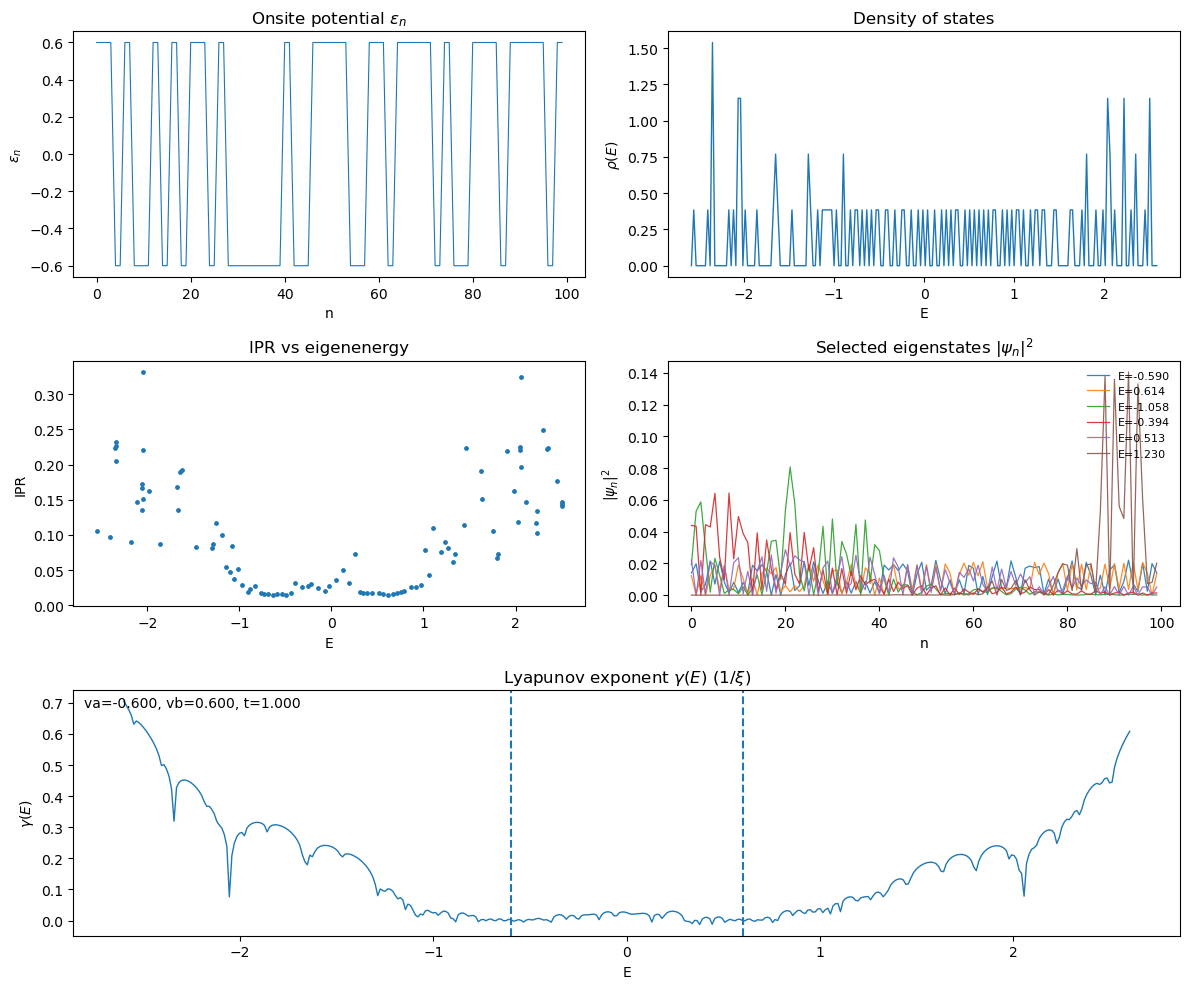

In [3]:
rdm = RandomDimerModel(N=100, t=1.0, va=-0.6, vb=+0.6, pair_prob=0.5, seed=1)
rdm.spectrum(k=600)   # or None for full spectrum on small N
fig = rdm.plot_all()